# Experiments 1. Logistic Regression

In [207]:
import numpy as np
import os
#import copy
#import time
#from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.config import config

In [208]:
from methods import gradf_inexact
from methods import GradientDescent, parse_logs
from methods import ConstantStepSize

In [209]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 2,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

In [210]:
config.update("jax_enable_x64", True)

In [211]:
path_pics = "../pics/"

In [213]:
def f1(w, X, Y, sigma=0):
    logit = -Y * (X@w)
    logit1 = jnp.clip(logit, None, 0)
    logit2 = jnp.clip(logit, 0, None)
    log = jnp.log(jnp.exp(logit1)+jnp.exp(-logit2)) + logit2
    return (log).sum() / len(Y) + sigma * (w**2).sum()

gradf = jax.grad(f1, argnums=0, has_aux=False)
jit_gradf = jax.jit(gradf)

## 0. Dataset

Creating of such dataset that logistic regression without regularization has finite solution

In [214]:
np.random.seed(1)
n, m = 100, 200
k = 10
X = np.random.randn(n, m)
X = np.vstack([X, X[-k:]])
w = np.random.randn(m)
Y = np.sign(X @ w)
Y[-k:] *= -1
X.shape, Y.shape, w.shape, np.linalg.norm(w)

((110, 200), (110,), (200,), 15.744252812419115)

In [215]:
np.random.seed(1)
n, m = 700, 200
k = 10

W, _ = np.linalg.qr(np.random.randn(m, m))
#W = np.eye(m)
X_base = W[:k]
X_w = np.random.randint(-10, 10, (n-2*k, k))
#X_w = (X_w.T / np.linalg.norm(X_w, 2, 1)).T
X = np.vstack([X_base, X_base, X_w @ X_base])
X = (X - X.mean(0))/X.std()
w = np.random.randn(m)
Y = np.sign(X@w)
Y[:k] *= -1
X.shape, Y.shape

((700, 200), (700,))

In [216]:
np.linalg.matrix_rank(X)

10

In [217]:
A = X
eigvals, _ = np.linalg.eigh(A.T @ A)
L = np.real((eigvals.max()) / 4 / A.shape[0])
L

6.042730110525059

In [218]:
sigma=0
gradf = lambda x: np.array(jit_gradf(x, X, Y, sigma).block_until_ready())
f = lambda x: f1(x, X, Y, sigma)

In [219]:
#w = np.random.randn(X.shape[-1])
f(w).item(), f(np.zeros(m)).item()

(0.07528045957456499, 0.6931471805599454)

## 1. Noise Distributed on the Unit Sphere

The case when $\xi \sim \mathcal{U}(S_1(0))$

In [220]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#Delta_list = [0]
N = int(1e5)
save_iter = int(1)
tol = 1e-9
methods = []
for Delta in Delta_list:
    tol = np.sqrt(6)*Delta
    grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 1)
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)
#001448072963264384

1e-05 2.4551983529132478e-05 0.048371330631296165 7.808537470952601 35498
0.0001 0.00024378725750968168 0.048409356381193945 7.5211040730399015 16973
0.001 0.0023445547054006905 0.050493710213625045 5.7307823337237895 3669
0.01 0.022809118583490096 0.07909042892412797 2.4111726683066554 218
0.1 0.21087735981132083 0.19971569788401383 0.7191610113628539 9


It is the gradient descent trajectory with stop condition

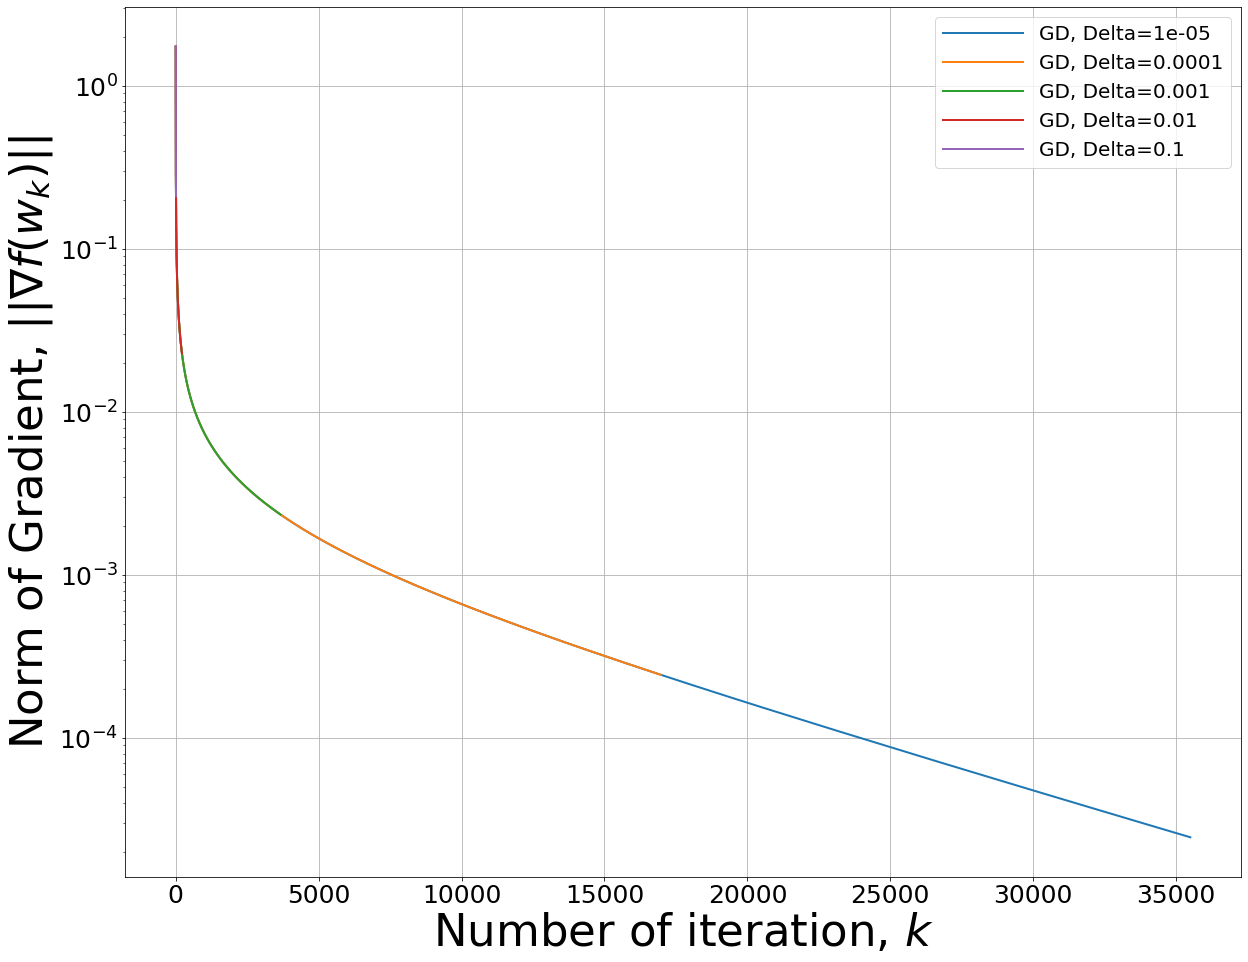

In [221]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig(os.path.join(path_pics, "grad.png"))

It is the gradient descent trajectory without stop condition

In [222]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#Delta_list = [0]
N = int(1e6)
save_iter = int(100)
tol = 1e-9
methods = []
for Delta in Delta_list:
    tol = 0
    grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 1)
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)

1e-05 3.4577798611278833e-07 0.04837091285387157 7.8426252011242745 10002
0.0001 3.866047720017305e-06 0.04837091288537029 7.842664993062965 10002
0.001 3.3866361393887286e-05 0.04837091534254589 7.843605446239785 10002
0.01 0.00031587304540915836 0.04837113444364582 7.998512249015672 10002
0.1 0.003882242110352774 0.04840430967824923 18.0605724165634 10002


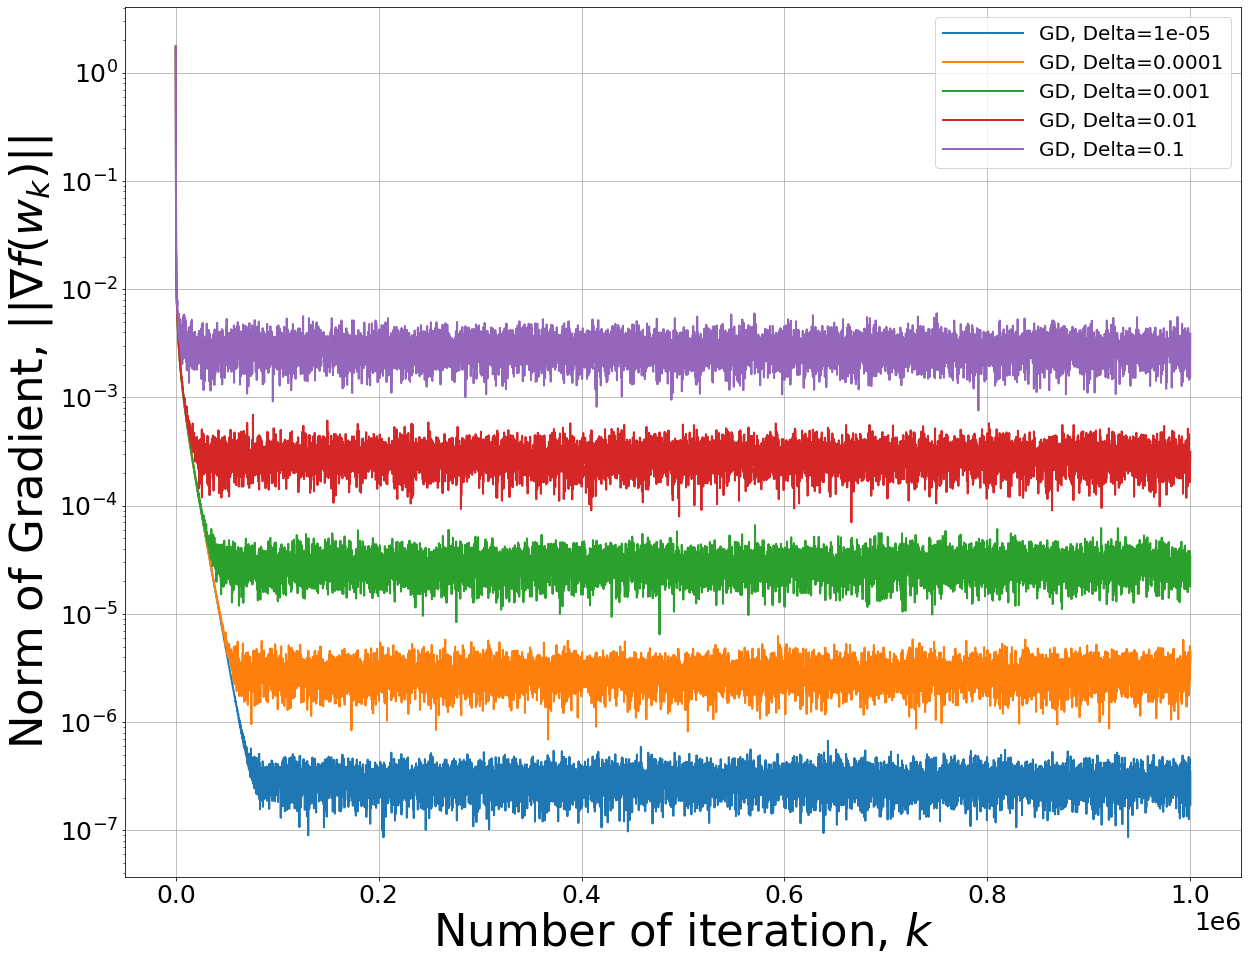

In [223]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig(os.path.join(path_pics, "grad_non_stop.png"))

Comparison of exact and inexact GD without stop condition. Below there are graphics for a gradient norm and a distance between current and start points.

In [230]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [0, 1e-1]
N = int(2e5)
save_iter = int(1)
tol = 0
methods = []
Delta = 1e-1
for Delta in Delta_list:
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, 1), tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)

0 8.41677161278094e-14 0.04837091285362551 7.842636707298056 200002
0.1 0.0019890557462038687 0.048385799050716966 10.600128104757117 200002


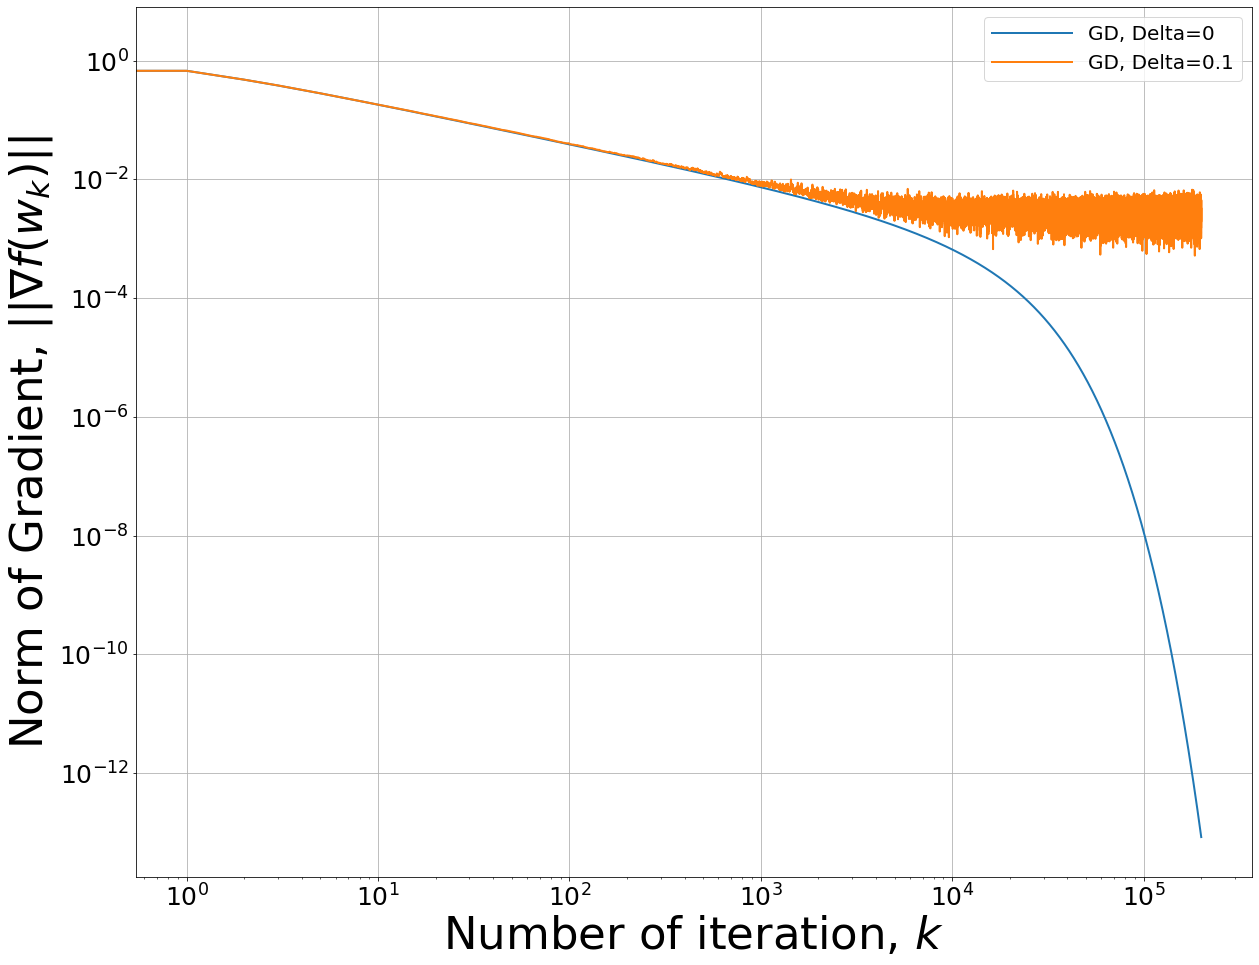

In [231]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.xscale("log")
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig(os.path.join(path_pics, "grad_delta.png"))

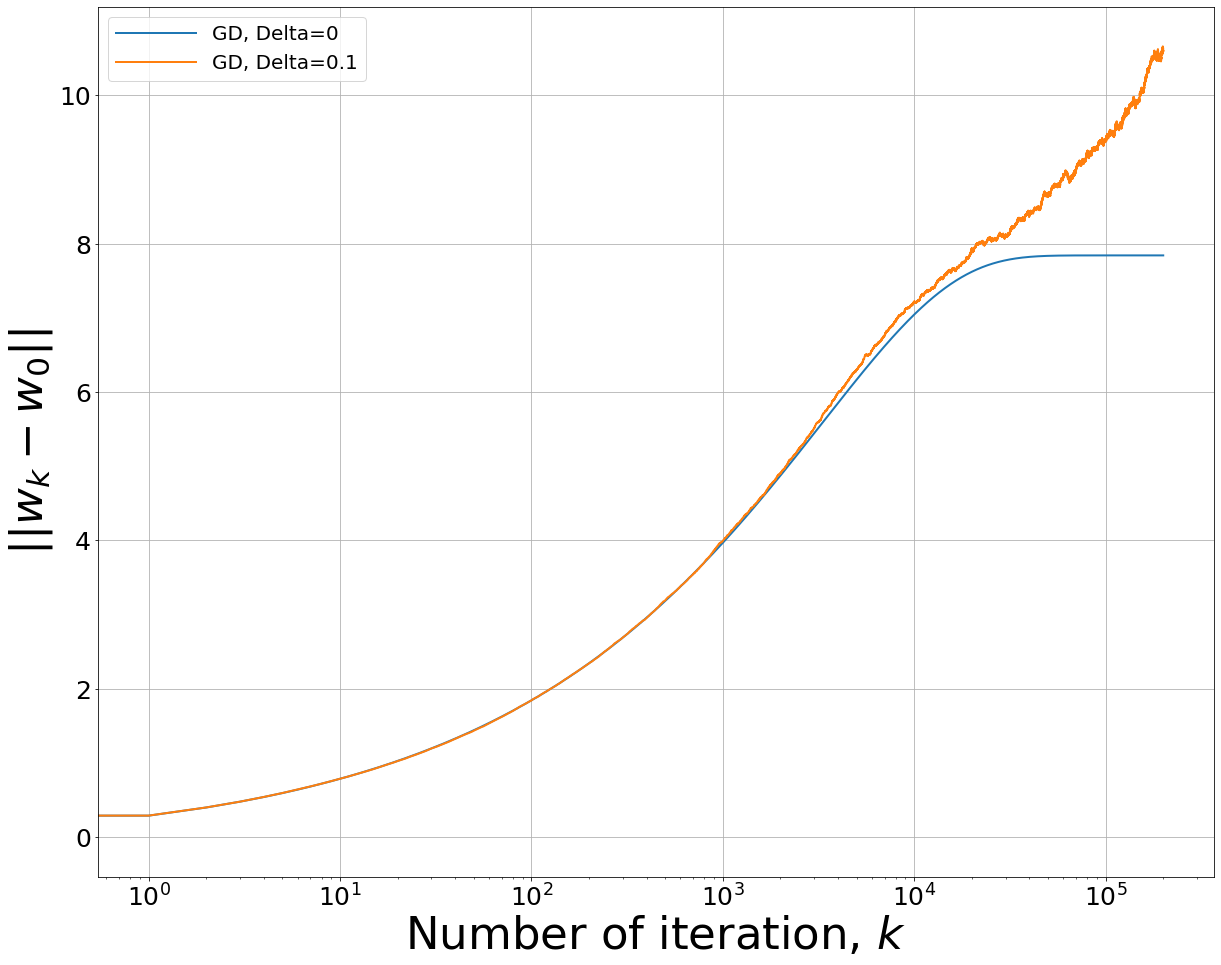

In [232]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(x-w)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.plot(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"$||w_k-w_0||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.xscale("log")
plt.savefig(os.path.join(path_pics, "norm_x_delta.png"))

## 2. Noise equaled Scaled Anti-gradient

The case when $\xi = -\Delta \nabla f(x)$

In [233]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
#Delta_list = [0]
N = int(1e5)
save_iter = int(1)
tol = 1e-9
methods = []
for Delta in Delta_list:
    tol = np.sqrt(6)*Delta
    grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 3)
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)
#001448072963264384

1e-05 3.449213226422691e-05 0.0483717349228903 7.79484232662983 35370
0.0001 0.00034493795949716707 0.04844557420817743 7.397919538773755 16360
0.001 0.0034493601159665903 0.052113026330134066 5.166789162842615 2954
0.01 0.03448732068645638 0.09166331815834722 1.9638803636801543 147
0.1 0.32506551990206184 0.24715058574768647 0.5376050766002262 6


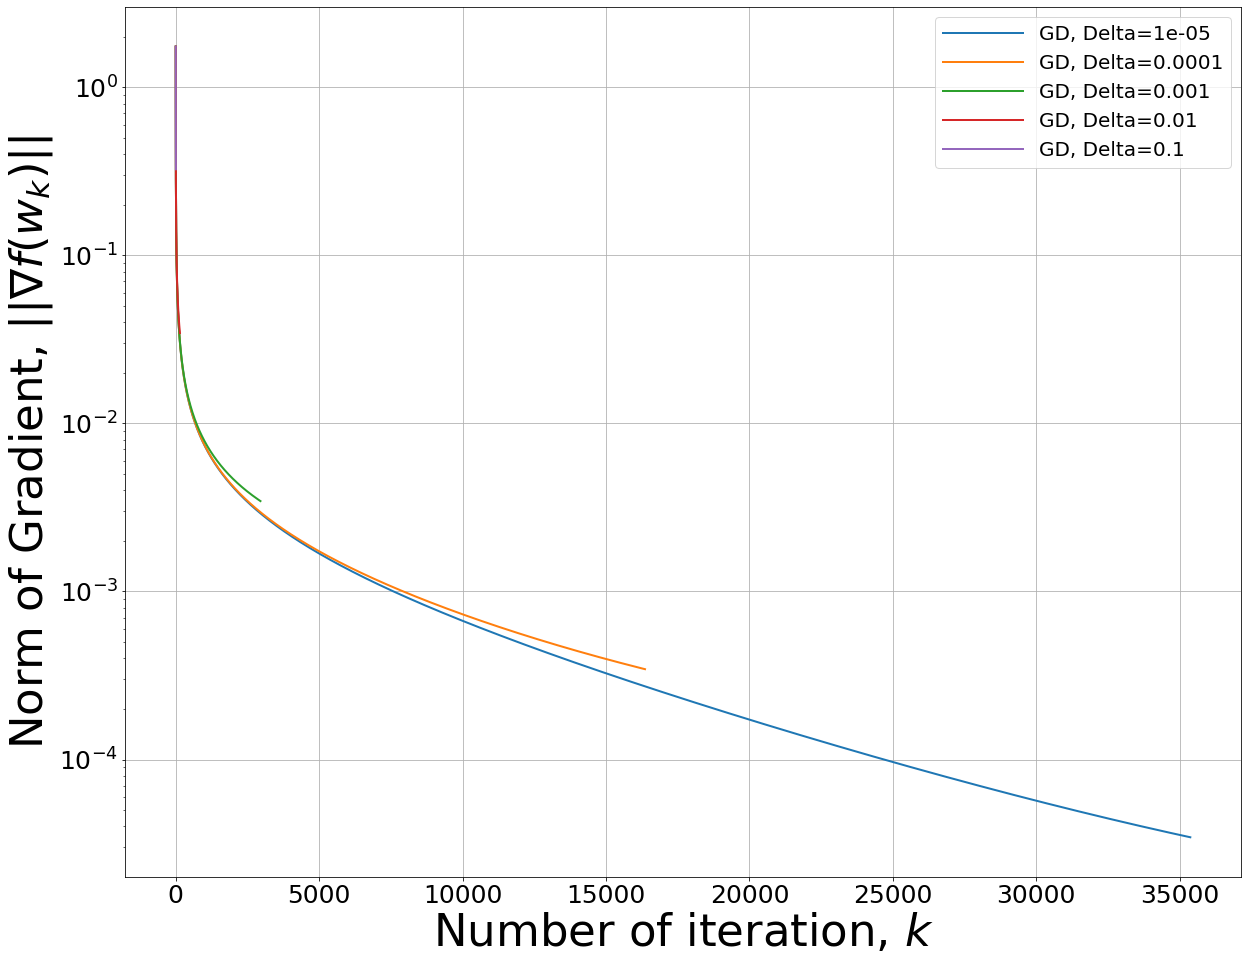

In [234]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig(os.path.join(path_pics, "grad3.png"))

In [235]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [0, 1e-1]
N = int(2e5)
save_iter = int(1)
tol = 0
methods = []
Delta = 1e-1
for Delta in Delta_list:
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, 3), tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)

0 8.41677161278094e-14 0.04837091285362551 7.842636707298056 200002
0.1 0.10000000000000016 0.14190742287663907 1.1140587301102154 200002


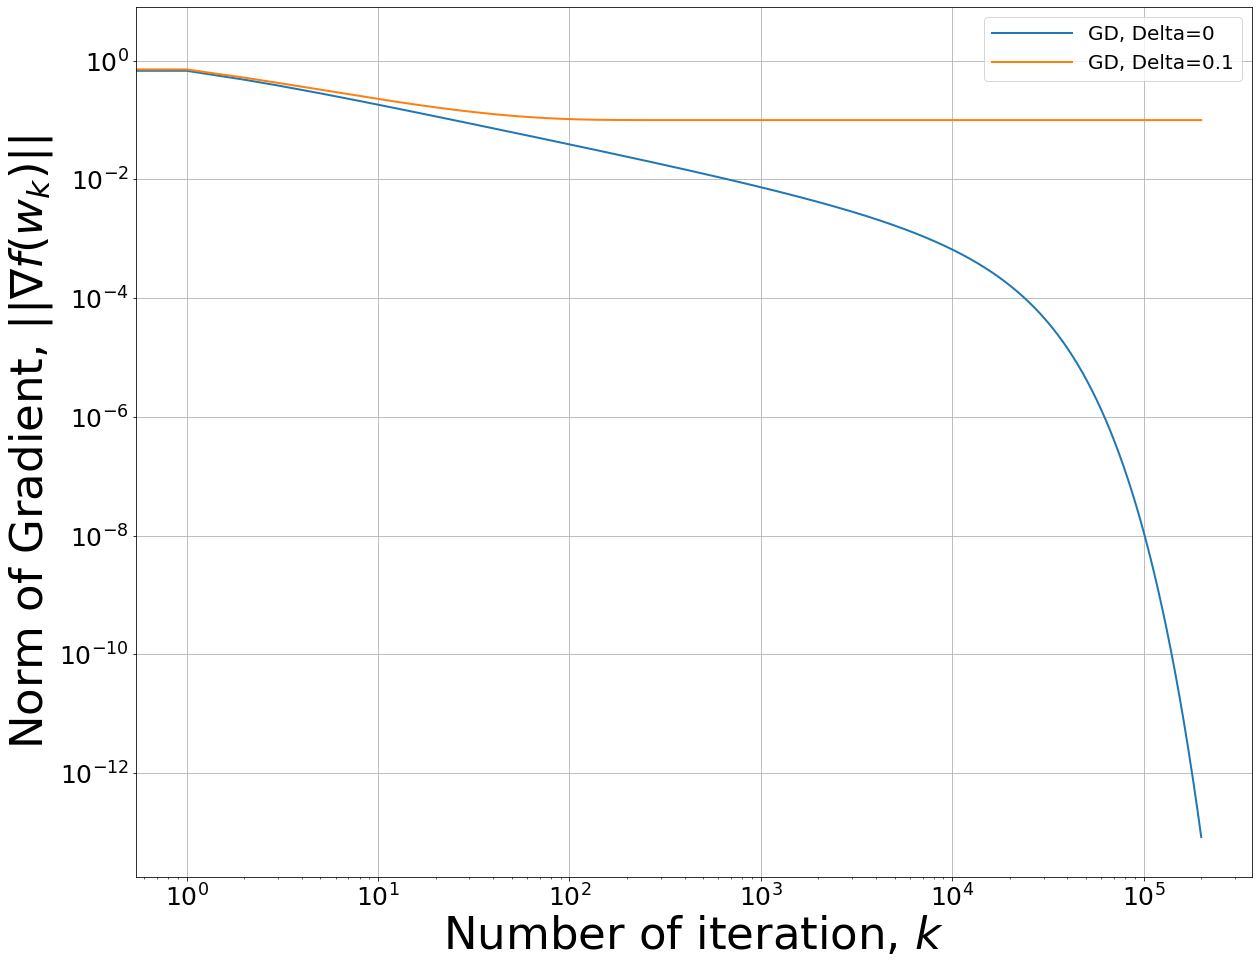

In [236]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.xscale("log")
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig(os.path.join(path_pics, "grad3_delta.png"))

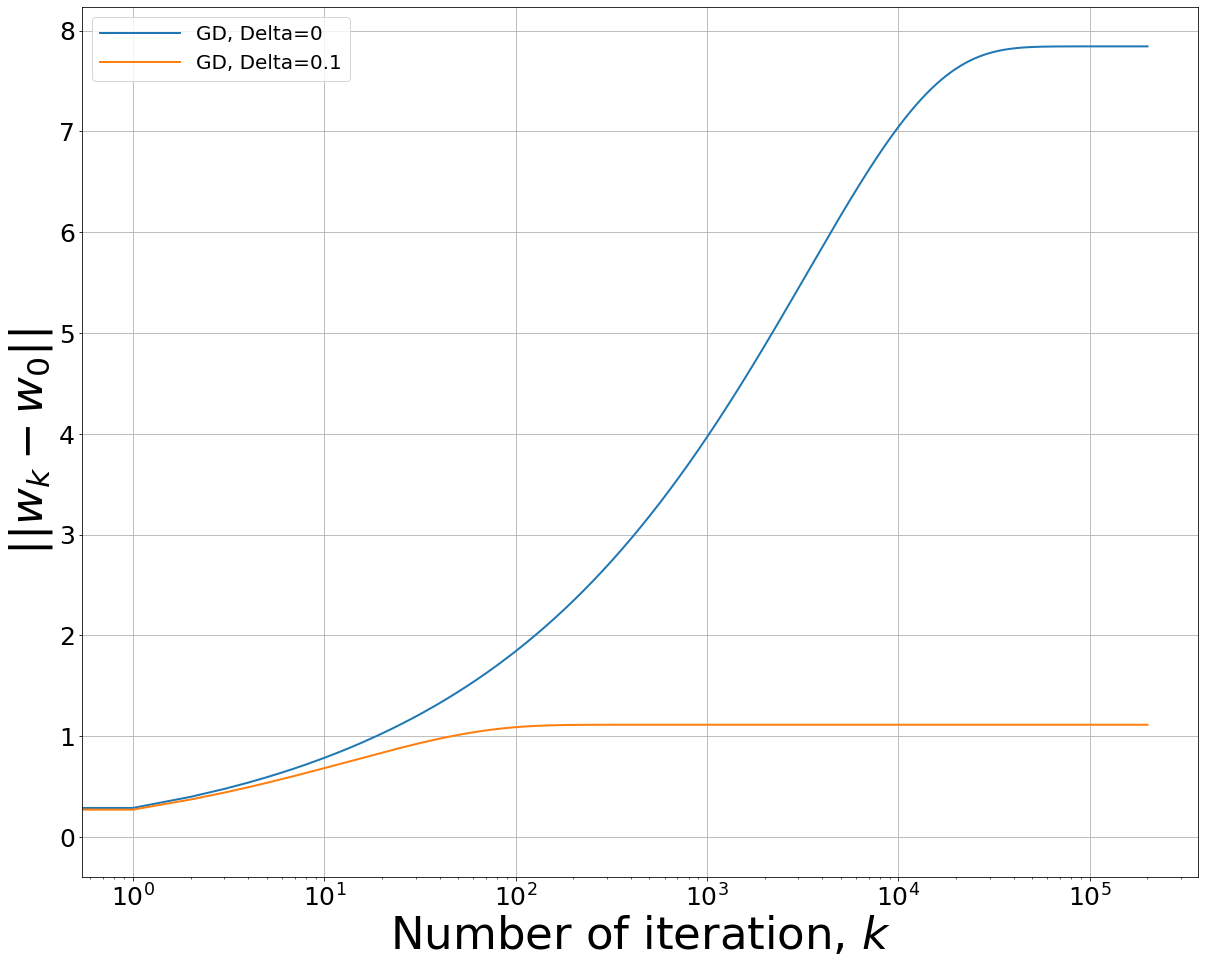

In [237]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(x-w)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.plot(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"$||w_k-w_0||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.xscale("log")
plt.savefig(os.path.join(path_pics, "norm_x3_delta.png"))

## 3. Noise is some constant noise

The case when $\xi = -\Delta v$. The $v$ is scaled in the function gradf_inexact

In [238]:
np.random.seed(1)
alpha = 1/L
w = np.zeros(X.shape[-1])
v = np.random.randn(*w.shape)
Delta_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
N = int(1e5)
save_iter = int(1)
tol = 1e-9
methods = []
for Delta in Delta_list:
    tol = np.sqrt(6)*Delta
    grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 4, v=v)
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)


1e-05 2.383064292336381e-05 0.04837130131417554 7.809963461426864 36187
0.0001 0.00023829615808882018 0.048407232288679866 7.535018565035659 17491
0.001 0.0023824826507036676 0.05052409936083963 5.748170519847207 3729
0.01 0.02381347742675894 0.08008142611226303 2.3922448435204338 213
0.1 0.2344286402465953 0.20974241266182658 0.6826985598444539 8


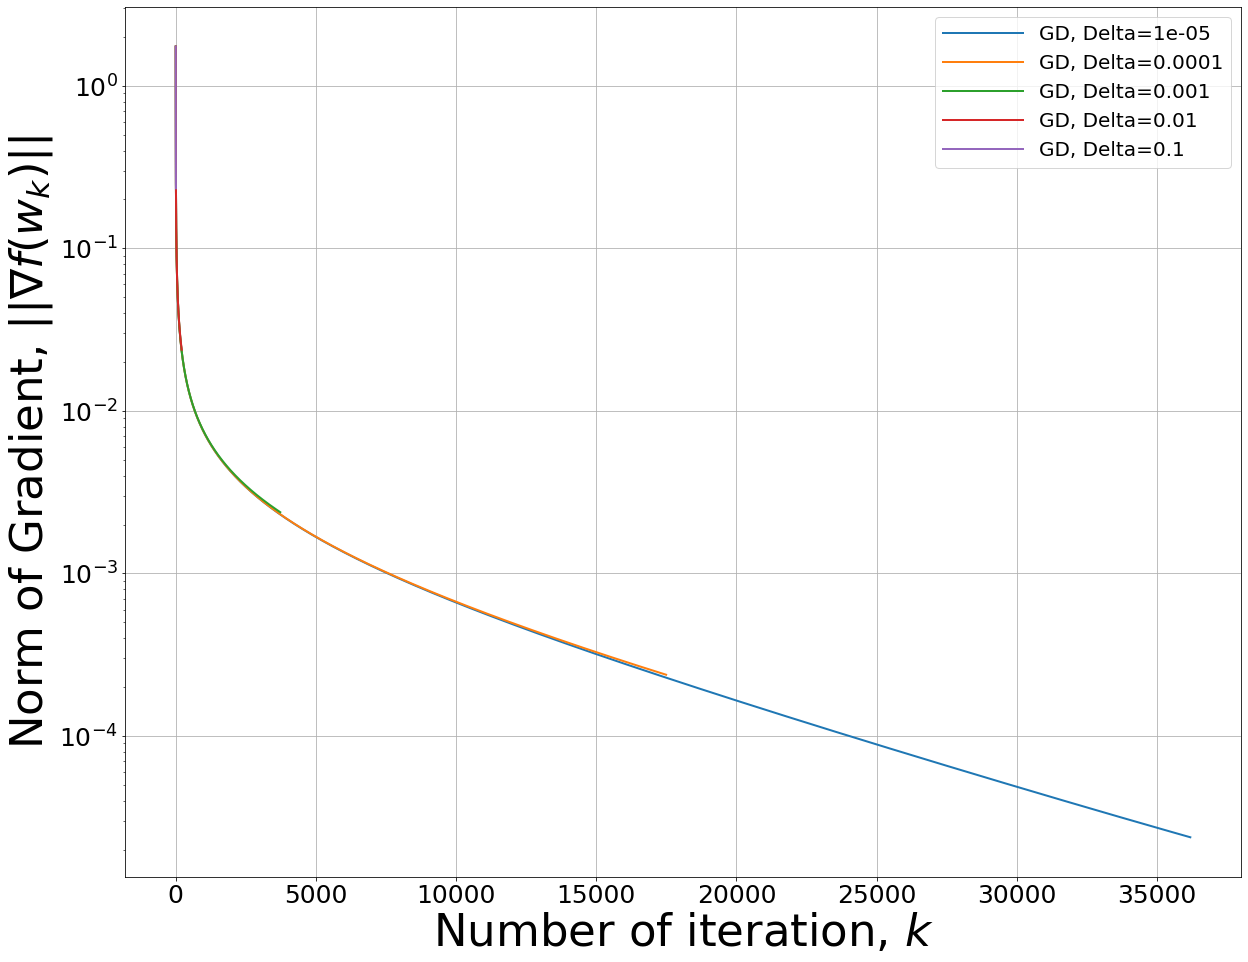

In [239]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig(os.path.join(path_pics, "grad4.png"))

In [240]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.zeros(X.shape[-1])
Delta_list = [0, 1e-1]
N = int(2e5)
save_iter = int(1)
tol = 0
methods = []
Delta = 1e-1
for Delta in Delta_list:
    method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
    x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, 4, v=v), tol=tol, max_iter=N)
    print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history))
    methods.append(method)

0 8.41677161278094e-14 0.04837091285362551 7.842636707298056 200002
0.1 0.0299111158864955 0.06426296322312329 3158.2532324734866 200002


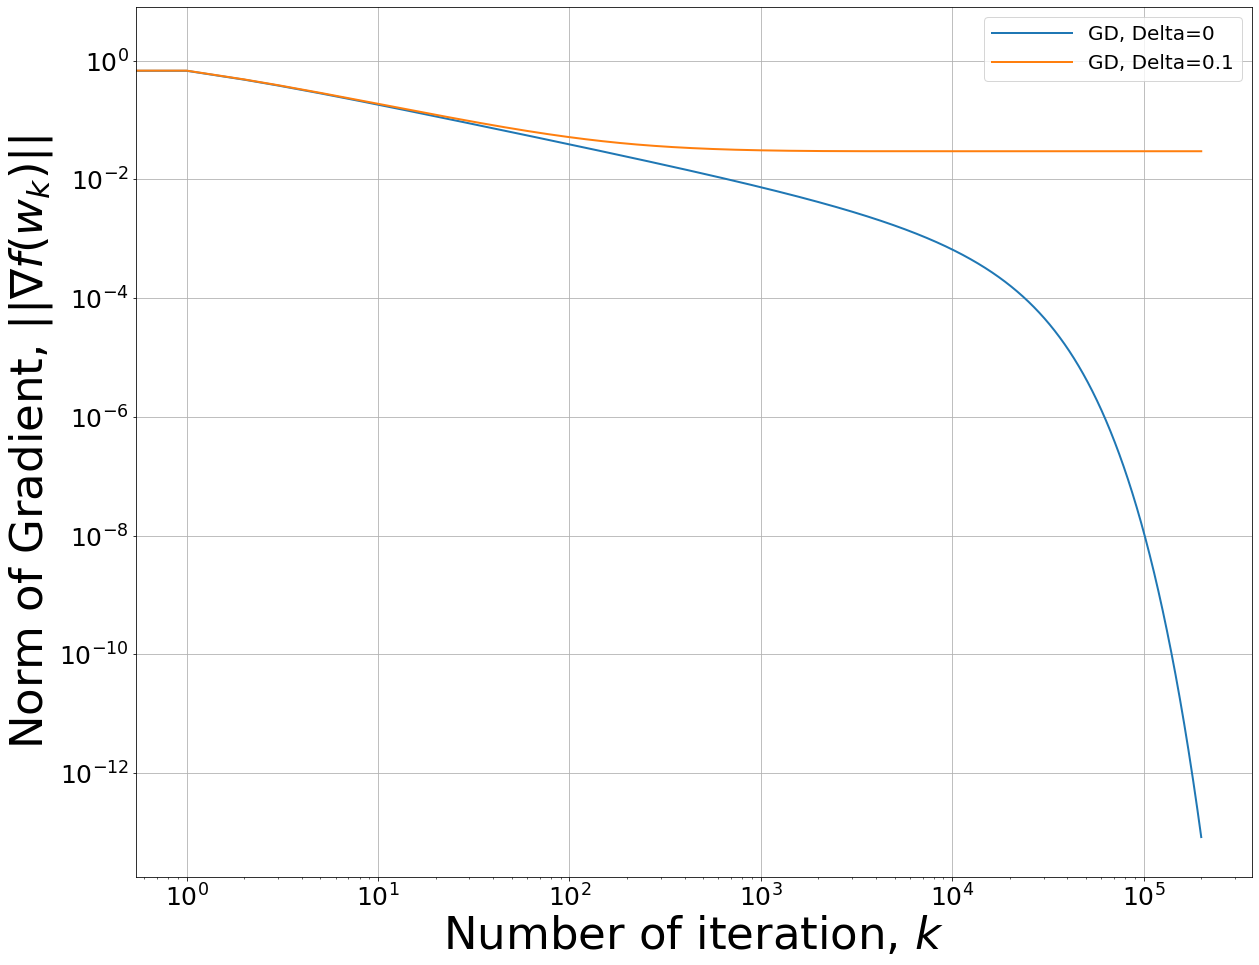

In [241]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(gradf(x))
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.xscale("log")
plt.ylabel(r"Norm of Gradient, $||\nabla f(w_k)||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.savefig(os.path.join(path_pics, "grad4_delta.png"))

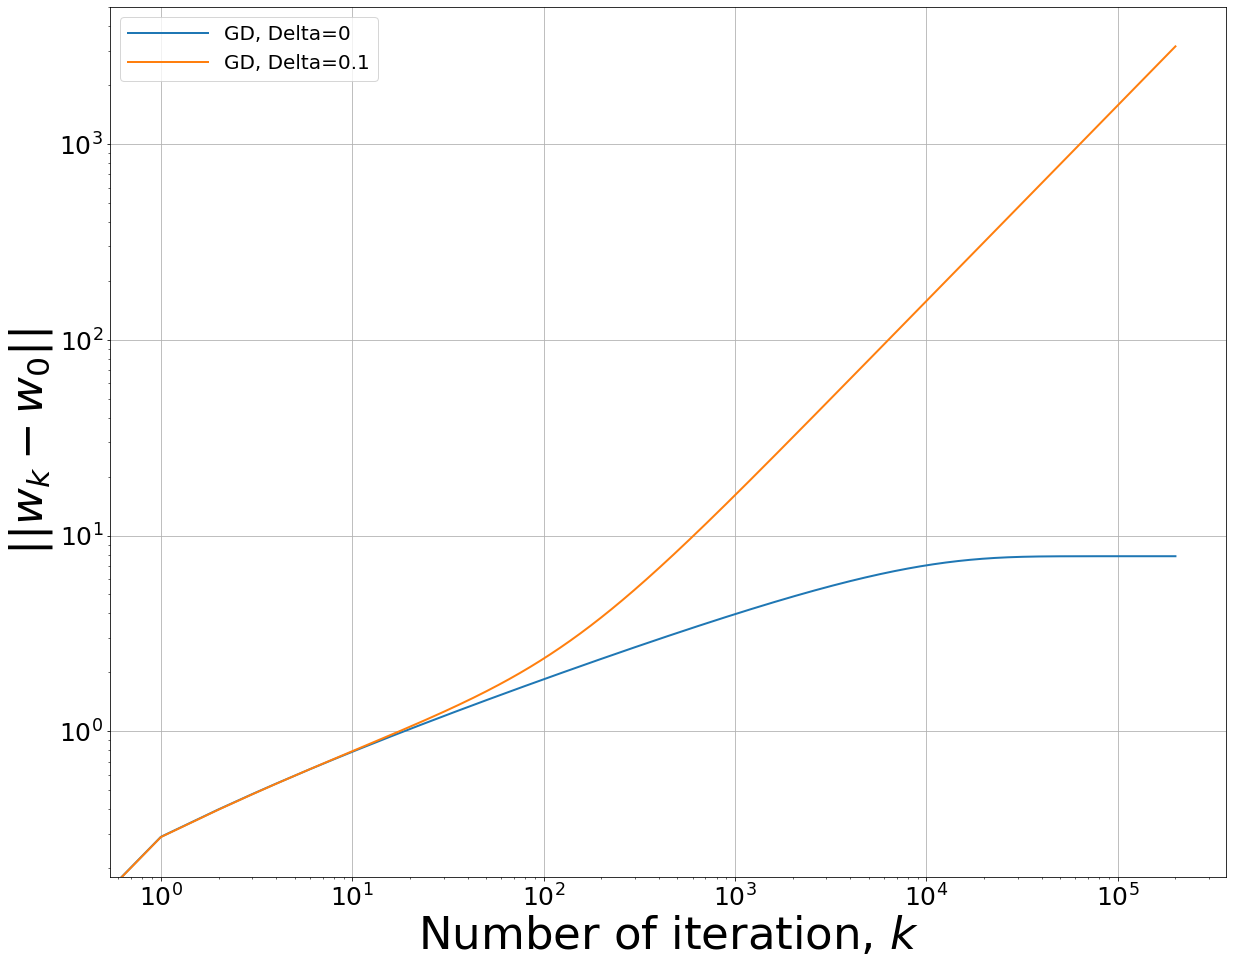

In [242]:
%matplotlib inline
plt.figure(figsize=(20, 16))
funcx = lambda x: np.linalg.norm(x-w)
for method in methods:
    xhistory = method.history
    times, values = parse_logs(method.history, ret_time=False, funcx=funcx)
    plt.semilogy(save_iter*np.array(times), values, "-", label=method.name)
plt.grid()
plt.ylabel(r"$||w_k-w_0||$")
plt.xlabel(r"Number of iteration, $k$")
plt.legend()
plt.xscale("log")
plt.savefig(os.path.join(path_pics, "norm_x4_delta.png"))

## 4. Trajectory Visualisation for Different Noise Types

In [194]:
np.random.seed(1)
n, m = 2, 2
X = np.array([[0, 1], [0, 1]])
Y = np.array([-1, 1])

In [195]:
f(np.zeros(2)-0.1)

DeviceArray(0.69439666, dtype=float64)

In [196]:
np.linalg.matrix_rank(X)

1

In [197]:
A = X
eigvals, _ = np.linalg.eigh(A.T @ A)
print(eigvals.max(), X.T @ X)
L = np.real((eigvals.max())/4 /A.shape[0])
L

2.0 [[0 0]
 [0 2]]


0.25

In [198]:
sigma=0
gradf = lambda x: np.array(jit_gradf(x, X, Y, sigma).block_until_ready())
f = lambda x: f1(x, X, Y, sigma)

In [205]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.ones(n)
v = np.ones(n)
Delta_list = [0, 1e-12]
N = int(100)
save_iter = int(1)
tol = 0
methods = []
Delta = 1e-3

Delta = 0
tol = np.sqrt(6)*Delta
#alpha = 1e-2
method = GradientDescent(ConstantStepSize(alpha), name="Exact", save_iter=save_iter)
x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, 4, v=v), tol=tol, max_iter=N)
print(tol)
print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history), x)
methods.append(method)
Delta = 1
grad_name = {1:"random inexactness",3:"-gradient",4:"constant inexactness",}
for dtype in [1,3,4]:
    tol = np.sqrt(6)*Delta
    method = GradientDescent(ConstantStepSize(alpha), name="{}".format(grad_name[dtype]), save_iter=save_iter)
    x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, dtype, v=v), tol=tol, max_iter=N)
    print(dtype, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history), x)
    methods.append(method)

0.0
0 0.0 0.6931471805599453 1.0 5 [1.00000000e+00 2.22044605e-16]
1 0.4820273492439935 2.0185200997270165 4.375202014118008 2 [1.77094562 4.00076796]
3 0.4833042713016903 2.054719516101568 4.196649368595868 2 [1.         4.07576569]
4 0.4400634820572633 1.4381385915280454 3.3045863205143755 2 [-1.82842712 -2.75266144]


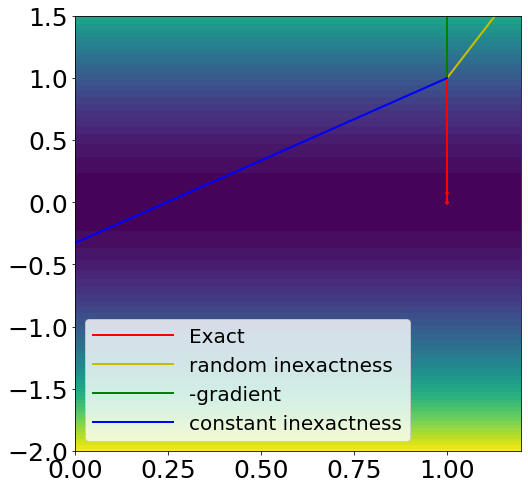

In [206]:
%matplotlib inline
l = 100
x, y = np.mgrid[-l:l,
                -l:l]
x = x / 50
y = y/50
z = np.zeros((2*l, 2*l))
for i in range(2*100):
    for j in range(2*100):
        z[i, j] = f(np.array([x[i, j], y[i, j]]))
#z = np.log(z+1e-16)+16
fig, ax = plt.subplots()
ax.contourf(x, y, z, levels=50)


color = ["r", "y", "green", "b"]
for indm, method in enumerate(methods):
    xhistory = method.history
    x_list = np.array([x for x, _ in xhistory])
    plt.plot(x_list[:, 0], x_list[:, 1], color=color[indm], label=method.name)
    for ind in range(len(x_list)-1):
        x, y = x_list[ind, 0], x_list[ind,1]
        dx, dy = x_list[ind+1, 0] - x_list[ind, 0], x_list[ind+1,1] - x_list[ind,1]
        if ind % 1 == 0:
            head_width=0.01
        else:
            head_width=0
        ax.arrow(x, y, dx, dy, color=color[indm], head_width=head_width)
plt.legend()
fig.set_figwidth(8)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"

plt.xlim(0, 1.2)
plt.ylim(-2, 1.5)
#plt.savefig(os.path.join(path_pics, "lineslogreg.png"))